In [7]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
from icecream import ic
from tqdm import tqdm
from get_data import *
from dataloader import *
from test_function import test

In [8]:
from torch.utils.data import Dataset, DataLoader


class custom_simple_dataset(Dataset):


    def __init__(self, data, window_size):

        self.data = data
        self.ws = window_size

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):

        inp = self.data[idx, :, :]
        label = self.data[idx, self.ws:, 1:]

        return inp, label


In [9]:
 #Define the LSTM model class

# Use the GPU if available
torch.set_default_dtype(torch.float64)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device="cpu"
print(device)

class LSTMmodel(nn.Module):

    def __init__(self, input_size, hidden_size, out_size, layers, window_size=4, stepsize=1, rungekutta=False):

        super().__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.ws = window_size
        self.rungekutta = rungekutta
        if stepsize==1:
         self.step_size = 1
        else:
         self.step_size = torch.nn.parameter.Parameter(torch.rand(1))

        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=layers, batch_first=True)

        # Define linear layer
        self.linear = nn.Linear(hidden_size, out_size)

    def forward(self, one_full_traj):

        seq = one_full_traj[:, 0:self.ws, :]
        lstm_out, hidden = self.lstm(seq)           
        pred = self.linear(lstm_out)
        #only update next step
        out = one_full_traj[:, self.ws-1:self.ws, 1:] + pred[:, -1: , :]

        derivatie_sv = pred[:, -1: , :]
        #out = one_full_traj[:, self.ws-1:self.ws, 1:] + pred

        if self.rungekutta == False:
            for t in range(1, self.ws): # für RK : range(1, self.ws + 2):

                tmp = torch.cat(( one_full_traj[:,self.ws+t:self.ws+t+1, 0:1] , out[:, (t-1):t,:]), dim=2)
                seq = torch.cat((one_full_traj[:, t:self.ws+(t-1), :], tmp), dim=1)
                lstm_out, hidden = self.lstm(seq)           
                pred = self.linear(lstm_out)
                out = torch.cat((out, one_full_traj[:, self.ws+(t-1): self.ws+t, 1:] + pred[:, -1: , :]), dim=1)

                derivatie_sv = torch.cat((derivatie_sv, pred[:, -1: , :]), dim=1)


            for t in range(self.ws, one_full_traj.size(dim=1) - self.ws):

                #wäre richtig!!!    
                seq = torch.cat((one_full_traj[:, t : t + self.ws, 0:1], out[:, t - self.ws : t , :]), dim=2)
                #war falsch
                #seq = torch.cat((out[:, t - self.ws : t , :],one_full_traj[:, t : t + self.ws, 0:1]), dim=2)
                
                lstm_out, hidden = self.lstm(seq)           
                pred = self.linear(lstm_out)

                out = torch.cat((out, out[:, t-1:t, :] + self.step_size * pred[:, -1: , :]), dim=1)

                derivatie_sv = torch.cat((derivatie_sv, pred[:, -1: , :]), dim=1)

        if  self.rungekutta == True:
            for t in range(1, self.ws + 2): # für RK : range(1, self.ws + 2):

                tmp = torch.cat(( one_full_traj[:,self.ws+t:self.ws+t+1, 0:1] , out[:, (t-1):t,:]), dim=2)
                seq = torch.cat((one_full_traj[:, t:self.ws+(t-1), :], tmp), dim=1)
                lstm_out, hidden = self.lstm(seq)           
                pred = self.linear(lstm_out)
                out = torch.cat((out, one_full_traj[:, self.ws+(t-1): self.ws+t, 1:] + pred[:, -1: , :]), dim=1)
            
            for t in range(self.ws, one_full_traj.size(dim=1) - self.ws - 2):
                # seq = torch.cat((out[:, t - self.ws : t , :], one_full_traj[:, t : t + self.ws, 0:1]), dim=2)
                
                # lstm_out, hidden = self.lstm(seq)           
                # pred = self.linear(lstm_out)

                # out = torch.cat((out, out[:, t-1:t, :] + pred[:, -1: , :]), dim=1)

                #Runge Kutta : 
                
                #y(n+1) = y(n) + h/6 * (k1 + 2k2 + 2k3 + k4)
                # k1 = f(y(n))          --- u1
                # k2 = f(y(n)+h/2*k1)   --- u2
                # k3 = f(y(n)+h/2*k2)   --- u2
                # k4 = f(y(n)+h*k3)     --- u3
                # We only have u at discrete steps -> use h = 2 such that y(n)+k1 = y(n+1) and so on

                #richtig wäre :
                seq = torch.cat((one_full_traj[:, t : t + self.ws + 2, 0:1], out[:, t - self.ws : t + 2 , :]), dim=2)
                #war falsch beim training!
                #seq = torch.cat((out[:, t - self.ws : t + 2 , :], one_full_traj[:, t : t + self.ws + 2, 0:1]), dim=2)

                inp1 = seq[:, 0:-2, :]

                lstm_out, hidden = self.lstm(inp1)           
                k1 = self.linear(lstm_out)

                inp2 = seq[:, 1:-1, :]
                #inp2 = seq[:, 0:-2, :]
                #inp2[:, :, 0:1] =  1/2 * (seq[:, 0:-2, 0:1] + seq[:, 1:-1, 0:1])
                inp2[:, -1:, 1:] = inp2[:, -1:, 1:] + k1[:, -1, :]

                lstm_out, hidden = self.lstm(inp2)           
                k2 = self.linear(lstm_out) 

                inp3 = seq[:, 1:-1, :]
                #inp3 = seq[:, 0:-2, :]
                #inp3[:, :, 0:1] =  1/2 * (seq[:, 0:-2, 0:1] + seq[:, 1:-1, 0:1])
                inp3[:, -1:, 1:] = inp3[:, -1:, 1:] + k2[:, -1, :]

                lstm_out, hidden = self.lstm(inp3)           
                k3 = self.linear(lstm_out)          

                #inp4 = seq[:, 1:-1, :]
                inp4 = seq[:, 2:, :]
                inp4[:, -1:, 1:] = inp4[:, -1:, 1:] + 2*k3[:, -1, :]

                lstm_out, hidden = self.lstm(inp4)           
                k4 = self.linear(lstm_out)  

                    # y(n+1) ist 2 steps in der zukunft wegen h = 2 ?!?
                res = out[:, t:t+1, :]  +  2/6 * (k1[:, -1, :] + 2*k2[:, -1, :] + 2*k3[:, -1, :] + k4[:, -1, :])
                out = torch.cat((out, res), dim=1)

            
        return out, hidden, derivatie_sv          
  

cuda:0


In [ ]:
a = torch.tensor([[[1,2],[1,2],[1,2],[1,2],[1,2]]])
b = torch.tensor([[[1,2,9],[1,2,9],[1,2,9],[1,2,9],[1,2,9]]])
c = torch.cat((a[:, 0 : 4, :], b[:, 0 : 4, 2:3]), dim=2)
a = a[:,0:-2,:]
print(c)

In [ ]:
#with future:

def fr(v):

#parBoost_gen.d_b  = 3.2;                    % Dämpfungskonste Booster in [Ns/m]  Update AP: 2021Feb alter Wert 33.184
#parBoost_gen.F_c  = 0.5;                      % Coulombreibkraft Booster in [N] Update AP: 2021Feb alter Wert: 1.53;

    return 0

def fk(s,v):

# % Paramter Kontaktmodell
# % Unterer Anschlag
# parBoost_gen.c_bwl = 166e3;          % Federkonstante unterer Anschlag in [N/m]
# parBoost_gen.d_bwl = 474;            % Dämpfungskonstante unterer Anschlag in [Ns/m]
# parBoost_gen.s_0bwl = 0.3e-4;        % Kontaktpunkt unterer Anschlag in [m] 
# % Oberer Anschlag
# parBoost_gen.c_bwu = 166e3;                         % Federkonstante oberer Anschlag in [N/m]
# parBoost_gen.d_bwu = 474;                           % Dämpfungskonstante oberer Anschlag in [Ns/m]
# parBoost_gen.s_0bwu = parBoost_gen.s_b_max - 0.12e-4;     % Kontaktpunkt oberer Anschlag in [m]
#parBoost_gen.s_b_max = 0.6e-3;                                      % Maximaler Hub in [m]

    s_u =  0.6e-3 - 0.12e-4
    c_u = 166e3
    d_u = 474

    c_l = 166e3
    s_l =  0.3e-4
    d_l = 474


    if s_u <= s:
        
        fk = -c_u * (s - s_u) - d_u * v * (s - s_u)

    elif s <= s_l:

        fk = c_l * (s - s_l) - d_l * v * (s - s_l)

    else:
        fk = 0

    return fk

def ODE_right_side(x_true, physics_rescaling):

    #rescale to physical units
    x_true[:,0] = x_true[:,0]*(physics_rescaling[0] - physics_rescaling[3]) + physics_rescaling[3]
    x_true[:,1] = x_true[:,1]*(physics_rescaling[1] - physics_rescaling[4]) + physics_rescaling[4]
    x_true[:,2] = x_true[:,2]*(physics_rescaling[2] - physics_rescaling[5]) + physics_rescaling[5]

    x_dt = x_true[:,:,1:] #take only position and speed
    x_dt[:,:,0:1] = x_true[:,:,2:] # write s' = v (v from real data)     
    #          v'  = 1/m ( A * ( p - p0) - c * (s - s0) + fr(v) + fk(s,v) )  

    m = 1.8931e-3                         # 1.8931e-3;              % Masse Booster in [kg]
    A = 0.5*(71.0526e-6 + 78.9793e-6 )  # 0.5*(parBoost_gen.A_b_closed + parBoost_gen.A_b_open);   % Mittlere Fläche Booster in [m²]                                
                                            # % Anfangswerte der Boostereinheit
    p0 = 1e5                                # parBoost_gen.s_b_0 = 3e-4;
    s0 = 3e-4                             # parBoost_gen.p_b_0 = 1e5;
    c = 16.5e3                              # parBoost_gen.c_b  = 16.5e3;                 % Federkonstante Booster in [N/m]

    for i in range(x_dt.size(dim=0)):
        for time in range(x_dt.size(dim=1)):

            p, s, v = x_true[i, time, 0], x_true[i, time, 1], x_true[i, time, 2]

            x_dt[i, time, 1:] =  1/m * ( A * ( p - p0) - c * (s - s0) + fr(v) + fk(s,v) ) 

    return x_dt

def train(input_data, model, weight_decay, learning_rate=0.001, ws=0, PSW_max=0):
 
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
 
    model.train()
    total_loss = []

    physics_loss = 0

    # s' = v
    # v' = f(s,v,p)
    # 
    # (s,v) = model return (we can also return the derivatives calculated by the model!)
    #
    # (s,v), (s', v') = model (return are vectors len = timesteps modulo init values)
    #  
    #  physic_error = 1/len * sum( mse ( (s', v') - (v, f(s,v,p))  ))
    #
    #  def f(s,v, p) from matlab (bad with normalisation!!!)
    #

  
    for k, (x,y) in enumerate(input_data):  # inp = (u, x) label = x
        
        x = x.to(device)
        y = y.to(device)
        
        output, _, derivative_sv = model(x)
  

        # calc physics loss


        physics_loss = loss_fn(derivative_sv, ODE_right_side(x[:, ws:, :], PSW_max))

        # reset the gradient
        optimizer.zero_grad(set_to_none=True)
        
        # calculate the error
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
 
        total_loss.append(loss.detach().cpu().numpy())
 
   # return the average error of the next step prediction
    return np.mean(total_loss)

In [25]:

params =           {
                           "experiment_number" : 2,
                           "window_size" : 4,
                           "h_size" : 5,
                           "l_num" : 1,
                           "epochs" : 100,
                           "learning_rate" : 0.001,
                           "part_of_data" : 100, 
                           "weight_decay" : 1e-5,
                           "percentage_of_data" : 0.6,
                           "future_decay"  : 0.5,
                           "batch_size" : 10,
                           "future" : 10,
                           "cut_off_timesteps" : 200,
                           "drop_half_timesteps": True
                        }


# Initialize the LSTM model
model = LSTMmodel(input_size=3, hidden_size=params["h_size"], out_size=2, layers=params["l_num"], window_size=params["window_size"], rungekutta=False).to(device)

# Generate input data (the data is normalized and some timesteps are cut off)
input_data, PSW_max = get_data(path = "save_data_test5.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data2, PSW_max = get_data(path = "Testruns_from_trajectory_generator_200.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data = input_data#torch.cat((input_data, input_data2))
print(input_data.size())

#Split data into train and test sets
np.random.seed(1234)
num_of_inits_train = int(len(input_data)*params["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])

train_data = input_data[train_inits,:input_data.size(dim=1)-params["cut_off_timesteps"],:]
test_data = input_data[test_inits,:,:]

# dataloader for batching during training
train_set = custom_simple_dataset(train_data, window_size=params["window_size"])
train_loader = DataLoader(train_set, batch_size=params["batch_size"], pin_memory=True)

losses = []
average_traj_err_train = []
average_traj_err_test = []

for e in tqdm(range(params["epochs"])):
    
    loss_epoch = train(train_loader, model, params["weight_decay"], learning_rate= params["learning_rate"], ws=params["window_size"], PSW_max = PSW_max)
    losses.append(loss_epoch)

    # Every few epochs get the error MSE of the true data
    # compared to the network prediction starting from some initial conditions
    if (e+1)%2 == 0:

        _,_, err_train = test(input_data, model, model_type = "or_lstm", window_size=params["window_size"], display_plots=False, num_of_inits = 20, set_rand_seed=True, physics_rescaling = PSW_max)

        average_traj_err_train.append(err_train)
        #average_traj_err_test.append(err_test)
        print(f"Epoch: {e}, the average next step error was : loss_epoch")
        print(f"Average error over full trajectories: training data : {err_train}")
                #print(f"Average error over full trajectories: testing data : {err_test}")

_,_, err_test = test(input_data, model, model_type = "or_lstm", window_size=params["window_size"], display_plots=False, num_of_inits = 100, set_rand_seed=True, physics_rescaling = PSW_max)
#_,_, err_test = test(test_data, model, steps=test_data.size(dim=1), ws=window_size, plot_opt=False, n = 100)
print(f"TRAINING FINISHED: Average error over full trajectories: testing data : {err_test}")
#print(f"TRAINING FINISHED: Average error over full trajectories: testing data : {err_test}")
        

torch.Size([100, 550, 3])


 10%|█         | 2/20 [00:22<03:25, 11.42s/it]

Epoch: 1, the average next step error was : loss_epoch
Average error over full trajectories: training data : 412777.587382679


 20%|██        | 4/20 [00:44<03:08, 11.77s/it]

Epoch: 3, the average next step error was : loss_epoch
Average error over full trajectories: training data : 344604.29986074916


 30%|███       | 6/20 [01:08<02:49, 12.12s/it]

Epoch: 5, the average next step error was : loss_epoch
Average error over full trajectories: training data : 184821.16065701222


 40%|████      | 8/20 [01:29<02:16, 11.41s/it]

Epoch: 7, the average next step error was : loss_epoch
Average error over full trajectories: training data : 96135.84165599411


 50%|█████     | 10/20 [01:54<02:04, 12.49s/it]

Epoch: 9, the average next step error was : loss_epoch
Average error over full trajectories: training data : 69788.71012725451


 60%|██████    | 12/20 [02:15<01:32, 11.59s/it]

Epoch: 11, the average next step error was : loss_epoch
Average error over full trajectories: training data : 44363.962130580614


 70%|███████   | 14/20 [02:38<01:10, 11.78s/it]

Epoch: 13, the average next step error was : loss_epoch
Average error over full trajectories: training data : 20817.42555982513


 80%|████████  | 16/20 [03:00<00:46, 11.70s/it]

Epoch: 15, the average next step error was : loss_epoch
Average error over full trajectories: training data : 7128.277212414496


 90%|█████████ | 18/20 [03:23<00:23, 11.68s/it]

Epoch: 17, the average next step error was : loss_epoch
Average error over full trajectories: training data : 207.51261167682603


100%|██████████| 20/20 [03:46<00:00, 11.33s/it]

Epoch: 19, the average next step error was : loss_epoch
Average error over full trajectories: training data : 50.6804747852147


TRAINING FINISHED: Average error over full trajectories: testing data : 250.4148410879593


torch.Size([240, 550, 3])
[350000.0, 0.0006, 1.7, 0.0, 0.0, -1.7]


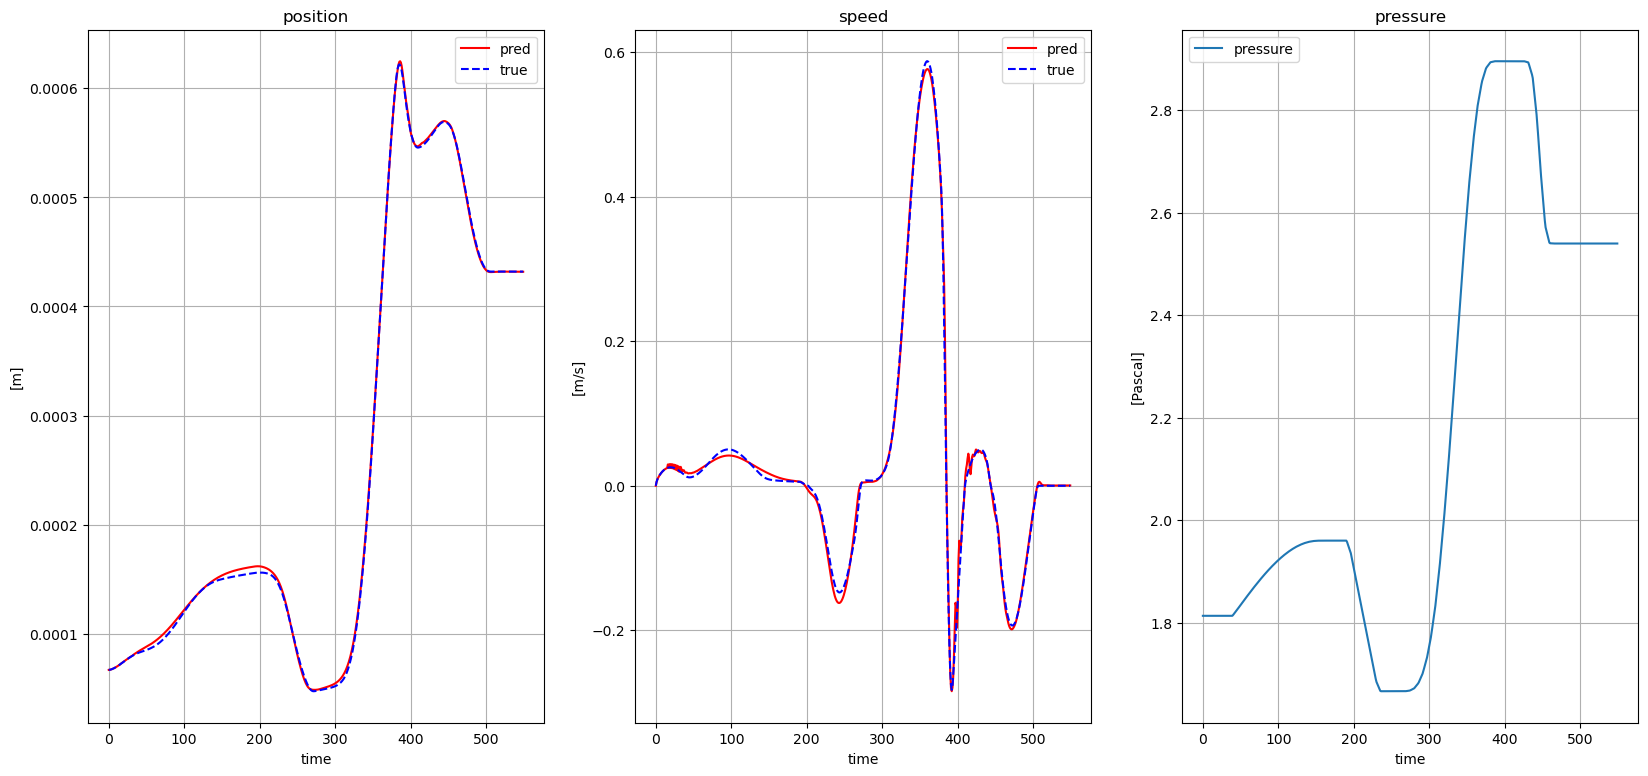

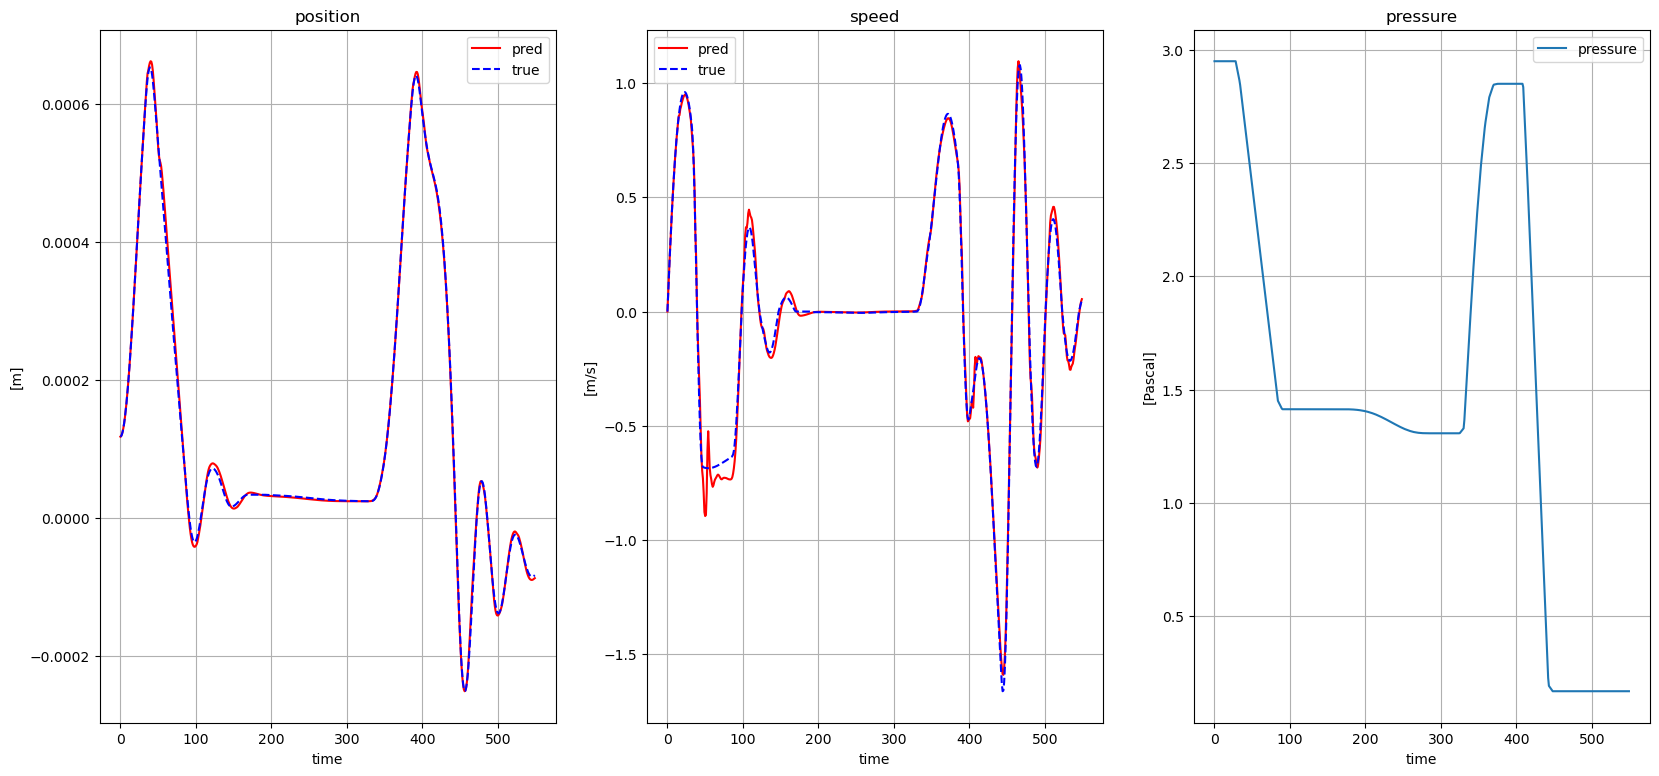

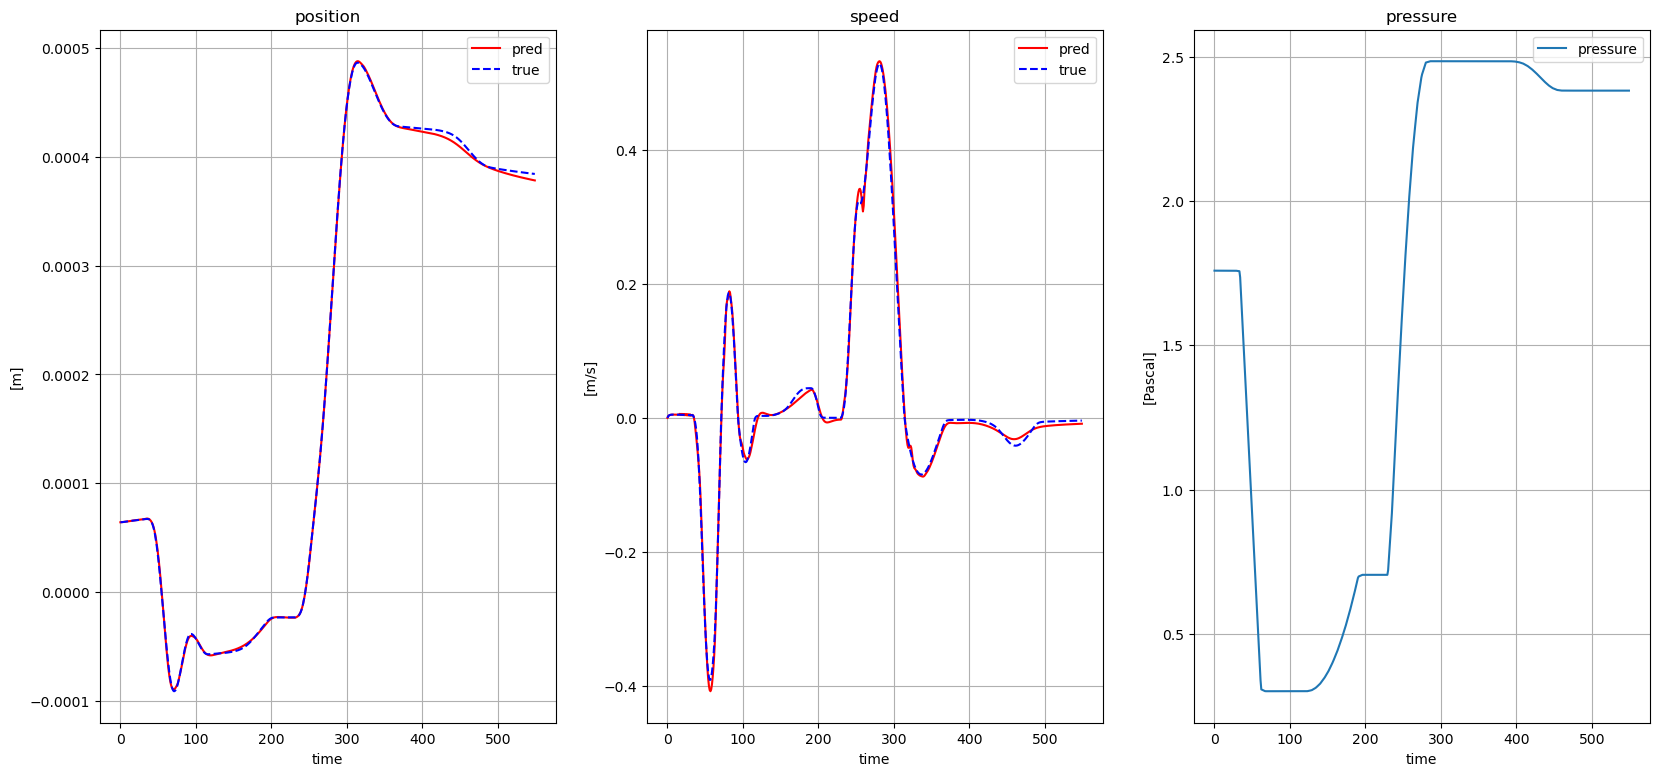

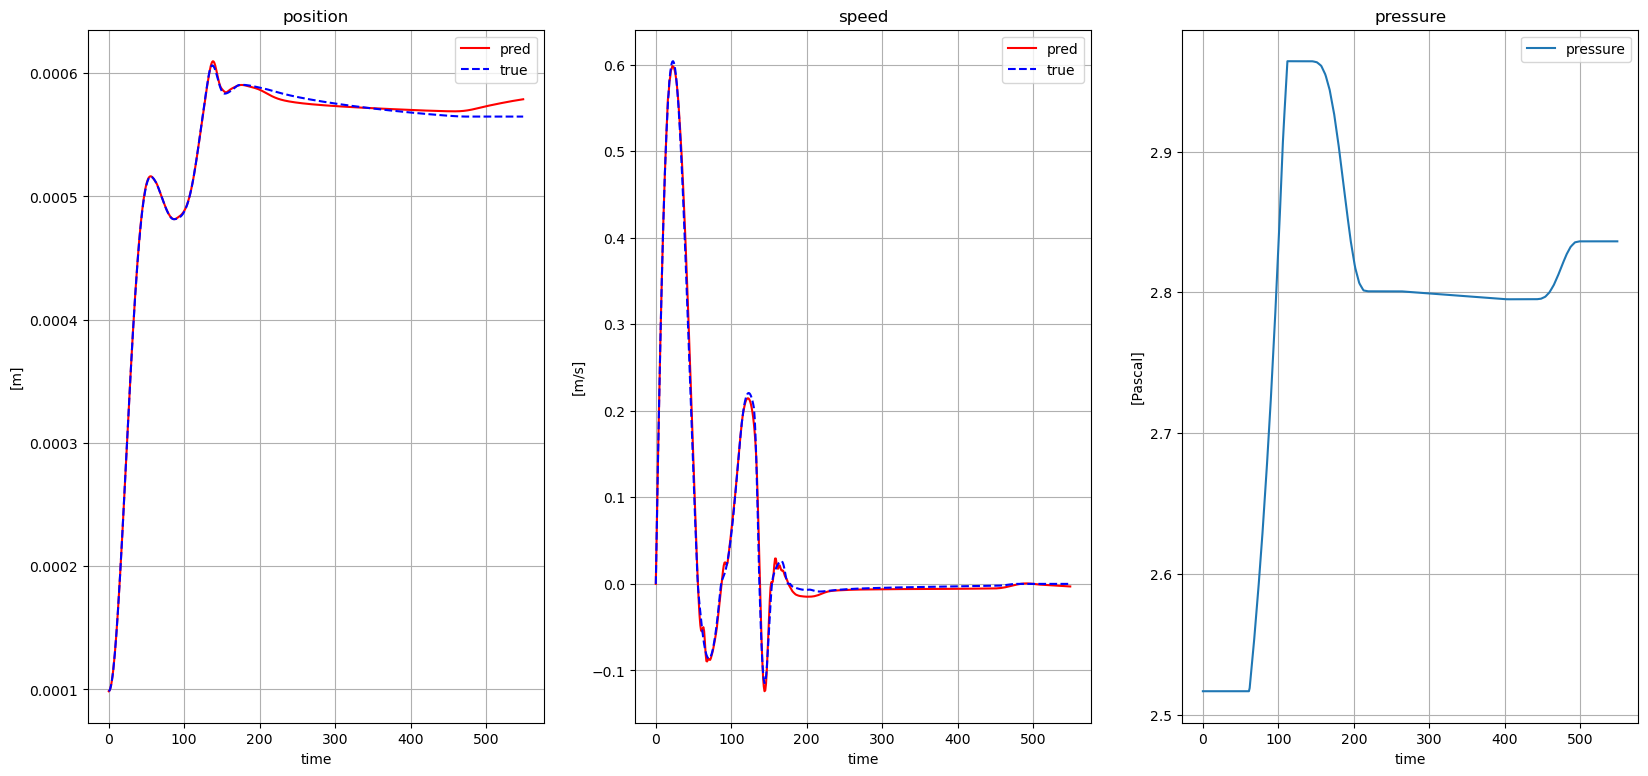

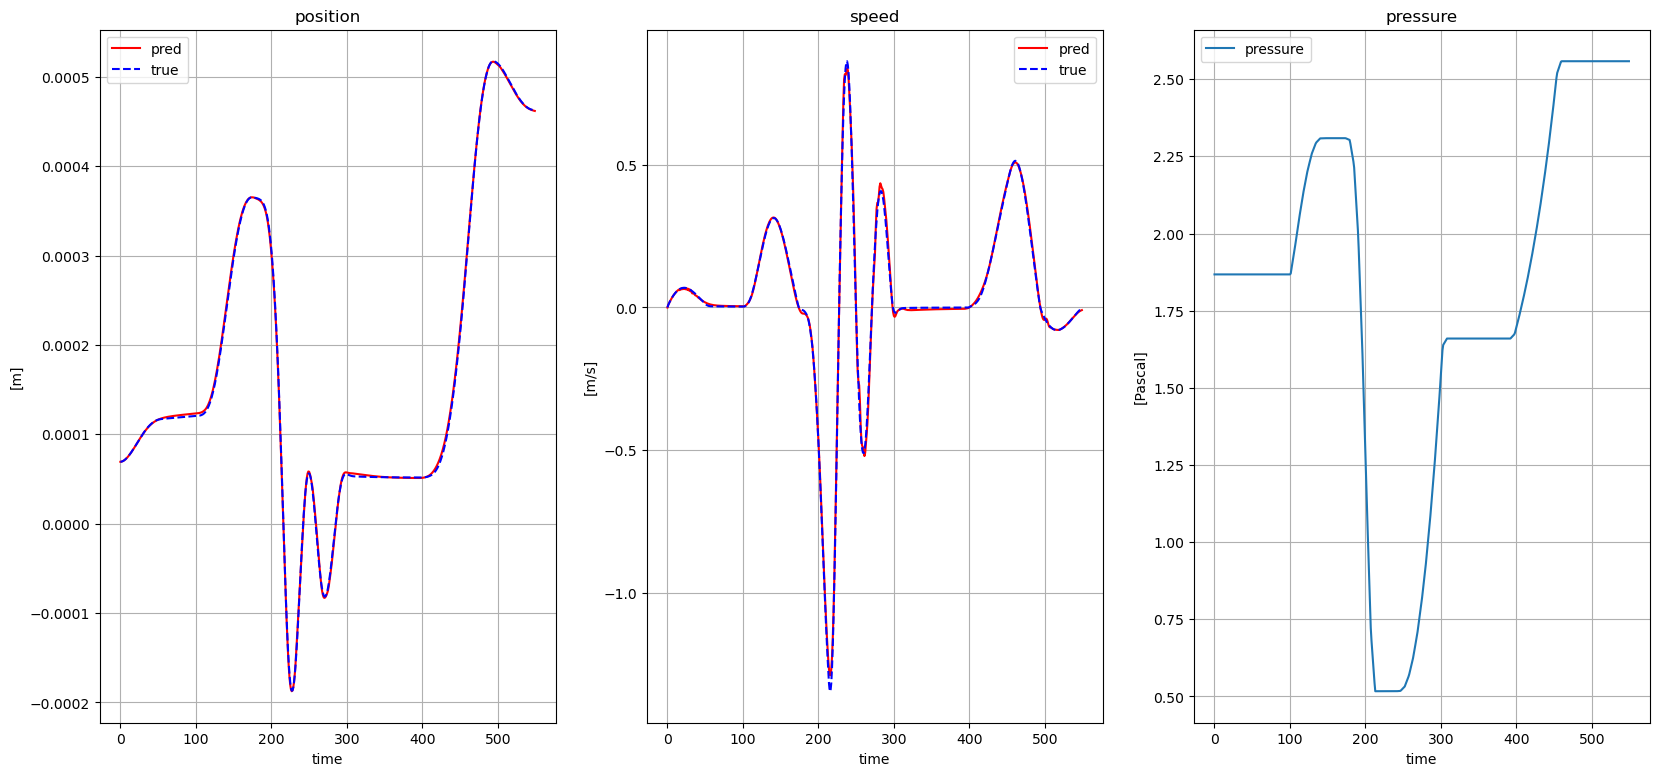

0.00018150659376899378


In [28]:
# Save the model
path = f"Ventil_trained_NNs\lstm_ws0.pth"
#
torch.save(model.state_dict(), path)

# Load the model and test it on the test data
path = "Ventil_trained_NNs\OR_lstm_1.pth"


params =                      {
                           "experiment_number" : 2,
                           "window_size" : 16,
                           "h_size" : 8,
                           "l_num" : 3,
                           "window_size" : 4,
                           "h_size" : 5,
                           "l_num" : 1,
                           "future_decay"  : 0.5,
                           "batch_size" : 20,
                           "future" : 10,
                           "cut_off_timesteps" : 0,
                           "drop_half_timesteps": True
                           }


input_data, PSW_max = get_data(path = "save_data_test4.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data2, PSW_max = get_data(path = "save_data_test5.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data3, PSW_max = get_data(path = "Testruns_from_trajectory_generator_200.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data = torch.cat((input_data, input_data2, input_data3))

#input_data = torch.cat((input_data, input_data2, input_data3))

#np.random.seed(1234)

num_of_inits_train = int(len(input_data)*params["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])
test_data = input_data[test_inits,:,:]
# Initialize the LSTM model

model = LSTMmodel(input_size=3, hidden_size=params["h_size"], out_size=2, layers=params["l_num"], window_size=params["window_size"], stepsize=1, rungekutta=False)

model.load_state_dict(torch.load(path, map_location=torch.device(device)))

train_data = input_data[train_inits,:,:]
# %matplotlib qt 
# %matplotlib inline #
print(test_data.size())
print(PSW_max)
test_loss, test_loss_deriv, total_loss = test(test_data[-5:], model, model_type = "or_lstm", window_size=params["window_size"], display_plots=True, num_of_inits = 10, set_rand_seed=False, physics_rescaling = PSW_max)
#test_loss, test_loss_deriv, total_loss = test(train_data, model, steps=input_data.size(dim=1), ws=params["window_size"], plot_opt=True , n = 1,  test_inits=len(test_data), rand=False, PSW_max=0)
print(total_loss)

#[350000.0, 0.0006, 1.7, 0.0, 0.0, -1.7]


In [ ]:
    # def forward(self, one_full_traj):

    #     seq = one_full_traj[:, 0:self.ws, :]
    #     lstm_out, hidden = self.lstm(seq)           
    #     pred = self.linear(lstm_out)
    #     #only update next step
    #     out = one_full_traj[:, self.ws-1:self.ws, 1:] + pred[:, -1: , :]
    #     #out = one_full_traj[:, self.ws-1:self.ws, 1:] + pred

    #     for t in range(1, self.ws):

    #         tmp = torch.cat(( one_full_traj[:,self.ws+t:self.ws+t+1, 0:1] , out[:, (t-1):t,:]), dim=2)
    #         seq = torch.cat((one_full_traj[:, t:self.ws+(t-1), :], tmp), dim=1)
    #         lstm_out, hidden = self.lstm(seq)           
    #         pred = self.linear(lstm_out)
    #         #only update next step
    #         out = torch.cat((out, one_full_traj[:, self.ws+(t-1): self.ws+t, 1:] +  pred[:, -1: , :]), dim=1)
    #        # out = torch.cat((out, one_full_traj[:, self.ws+(t-1): self.ws+t, 1:] +  pred), dim=1)

    #     for t in range(self.ws, one_full_traj.size(dim=1) - self.ws):
    #         seq = torch.cat((out[:, t - self.ws : t , :], one_full_traj[:, t : t + self.ws, 0:1]), dim=2)
            
    #         lstm_out, hidden = self.lstm(seq)           
    #         pred = self.linear(lstm_out)
    #         #only update next step
    #         out = torch.cat((out, out[:, t-1:t, :] + pred[:, -1: , :]), dim=1)
    #         #out = torch.cat((out, out[:, t-self.ws:t, :] + pred), dim=1)


    #     return out, hidden   